# Imports

In [1]:
import numpy as np
import nltk.corpus
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import lightgbm as lgb

# Reading the database

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
data.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
# No. of positive tweets
data[data['label'] == 0].count()

id       29720
label    29720
tweet    29720
dtype: int64

In [7]:
# No of negative tweets
data[data['label'] == 1].count()

id       2242
label    2242
tweet    2242
dtype: int64

# Preprocessing the data

In [8]:
data.dropna(inplace=True)

##### Removing the user tags

In [9]:
def clean_tags(tweet):
    tags = re.findall("@[\w]*", tweet)
#     print(tags)
    for i in tags:
        tweet = str.replace(tweet, i, "")
    return tweet

In [10]:
data['cleaned_tweets'] = data['tweet'].apply(clean_tags)
data.head()

,id,label,tweet,cleaned_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


##### Removing the punctuations

In [11]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
def clean_punctuations(tweet):
    punctuations = r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'
    tweet = re.sub(punctuations, "", tweet)
    return tweet
# string.punctuation

In [13]:
# print(type(string.punctuation))
data['cleaned_tweets'] = data['cleaned_tweets'].str.replace("[^A-Za-z#]", " ")
data['cleaned_tweets'].head(-5)
# data['cleaned_tweets'].iloc[31957]

/tmp/ipykernel_11739/1869601397.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['cleaned_tweets'] = data['cleaned_tweets'].str.replace("[^A-Za-z#]", " ")


0          when a father is dysfunctional and is so sel...
1          thanks for #lyft credit i can t use cause th...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide  society now    #motivation
                               ...                        
31952                             you went too far with   
31953    good morning #instagram #shower #water #berlin...
31954    #holiday   bull up  you will dominate your bul...
31955    less than   weeks                           #i...
31956    off fishing tomorrow  carnt wait first time in...
Name: cleaned_tweets, Length: 31957, dtype: object

##### Removing words less than a given size

In [14]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(lambda x : ["".join(word) for word in x.split() if len(word) > 4])

In [15]:
data['cleaned_tweets']

0        [father, dysfunctional, selfish, drags, dysfun...
1        [thanks, #lyft, credit, cause, offer, wheelcha...
2                                        [bihday, majesty]
3                                                 [#model]
4                       [factsguide, society, #motivation]
                               ...                        
31957                                              [youuu]
31958    [turner, airwaves, trying, herself, mantle, ge...
31959                  [listening, songs, monday, morning]
31960     [#sikh, #temple, vandalised, #calgary, condemns]
31961                                      [thank, follow]
Name: cleaned_tweets, Length: 31962, dtype: object

In [16]:
def joinWords(tweet):
    ans = ""
    for word in tweet:
        ans = " ".join(tweet)
    return ans

In [17]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(joinWords)

In [18]:
data['cleaned_tweets']

0           father dysfunctional selfish drags dysfunction
1        thanks #lyft credit cause offer wheelchair #di...
2                                           bihday majesty
3                                                   #model
4                           factsguide society #motivation
                               ...                        
31957                                                youuu
31958    turner airwaves trying herself mantle genuine ...
31959                       listening songs monday morning
31960           #sikh #temple vandalised #calgary condemns
31961                                         thank follow
Name: cleaned_tweets, Length: 31962, dtype: object

###### Lemmatization

In [19]:
from nltk.stem import WordNetLemmatizer

In [20]:
lemmer = WordNetLemmatizer()

In [21]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(lambda x : [lemmer.lemmatize(word) for word in x.split()])
data['cleaned_tweets'] = data['cleaned_tweets'].apply(joinWords)

In [22]:
data['cleaned_tweets'].head(-5)

0            father dysfunctional selfish drag dysfunction
1        thanks #lyft credit cause offer wheelchair #di...
2                                           bihday majesty
3                                                   #model
4                           factsguide society #motivation
                               ...                        
31952                                                     
31953    morning #instagram #shower #water #berlin #ber...
31954                    #holiday dominate direct whatever
31955       week #ibiza#bringiton#mallorca#holidays#summer
31956                    fishing tomorrow carnt first year
Name: cleaned_tweets, Length: 31957, dtype: object

##### Removing Hashtags

In [23]:
def removeHashtags(tweet):
    tags = re.findall("#[\w]*", tweet)
#     print(tags)
    for i in tags:
        tweet = str.replace(tweet, i, "")
    return tweet

In [24]:
data['cleaned_tweets'] = data['cleaned_tweets'].apply(removeHashtags)
# count = 0
# for i in data['cleaned_tweets'].iloc[31953].split():
#     count += 1
# print(count)

# Exploratory Data Analysis

##### Calculating Length of each tweet

In [25]:
data['length'] = data['cleaned_tweets'].apply(lambda x : len(x))
data.head(-5)

,id,label,tweet,cleaned_tweets,length
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag dysfunction,45
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks credit cause offer wheelchair,39
2,3,0,bihday your majesty,bihday majesty,14
3,4,0,#model i love u take with u all the time in ...,,0
4,5,0,factsguide: society now #motivation,factsguide society,19
...,...,...,...,...,...
31952,31953,0,@user you went too far with @user,,0
31953,31954,0,good morning #instagram #shower #water #berlin...,morning citygirl,24
31954,31955,0,#holiday bull up: you will dominate your bul...,dominate direct whatever,25
31955,31956,0,less than 2 weeks ð ðð¼ð¹ððµ @us...,week,5


##### Checking to see if length dictates the sentiment of tweet

<Axes: xlabel='label', ylabel='length'>

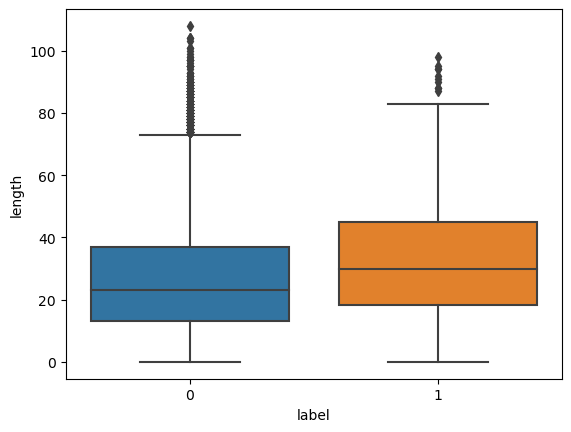

In [26]:
sns.boxplot(data = data, x = 'label', y = 'length')

##### Count of positive and negative tweets

<Axes: xlabel='label', ylabel='count'>

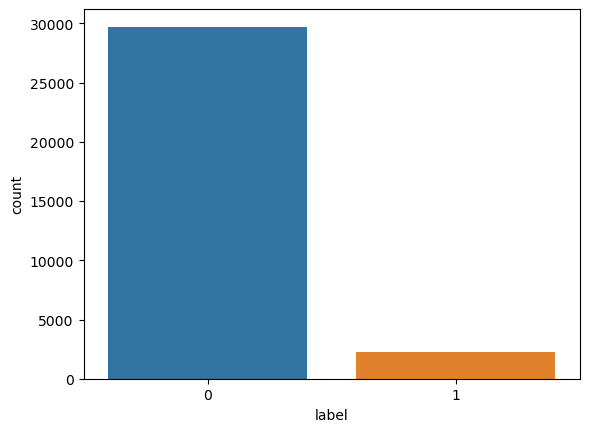

In [27]:
sns.countplot(data = data, x = 'label')

# Creating and training the model

##### Creating a bag of words

In [28]:
# def joinWords(tweet):
#     ans = ""
#     for word in tweet:
#         ans = " ".join(tweet)
#     return ans

In [29]:
allWords = ""
for tweet in data['cleaned_tweets']:
    allWords = allWords + tweet + " "

allWords = allWords.rstrip()
allWords

'father dysfunctional selfish drag dysfunction thanks  credit cause offer wheelchair   bihday majesty  factsguide society  talking before leave chaos dispute there  camping tomorrow danny school exam think about            cavaliers welcome  consumer price index climbed previous     selfish    shooting      daddy today  call  middle school build chant  comment       junior angry   thankful having paner   retweet agree  smile around  people essential chemical  people blaming conceded rooney knowing there little       product happy   drink lumpy prove lumpy      beautiful vendor         sunday  great panel mediatization public service happy father people nightclub night action mean those people their family forever  never chance presidential candidate excited about cycle look different      fellow nohern ireland sadley passed tonight forever singing cheering monday cloudy weather disabling oxygen production today   unbelievable century something again    dominate direct whatever morning 

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
count_vect = CountVectorizer(stop_words = 'english')

In [32]:
count_vect = count_vect.fit_transform(data['cleaned_tweets'])

In [33]:
count_vect = count_vect.astype(np.float64)

##### Splitting the data

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [35]:
x = count_vect;
y = data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

##### Creating a model (LightGBM)

In [36]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

/home/newbie/anaconda3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's binary_logloss: 0.195797	valid_0's binary_logloss: 0.207972
[40]	training's binary_logloss: 0.186399	valid_0's binary_logloss: 0.201421
[60]	training's binary_logloss: 0.181057	valid_0's binary_logloss: 0.198859
[80]	training's binary_logloss: 0.177349	valid_0's binary_logloss: 0.197211
[100]	training's binary_logloss: 0.17385	valid_0's binary_logloss: 0.196673


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

##### Creating a model (Logistic Regression)

In [37]:
model2 = LogisticRegression(random_state = 42)
model2.fit(x_train, y_train)

LogisticRegression(random_state=42)

##### Creating a model (Random Forrest Classifier)

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
model3 = RandomForestClassifier(random_state = 42, verbose = 2)

In [40]:
model3.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.2min finished


RandomForestClassifier(random_state=42, verbose=2)

##### Creating a model (Decision Tree)

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
model4 = DecisionTreeClassifier(random_state = 42)

In [43]:
model4.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

# Making Predictions

##### Predictions from LightGBM classifier

In [44]:
pred = model.predict(x_test)

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
print(accuracy_score(pred, y_test))

0.9381583063927417


##### Predictions from Logistic Regression model

In [47]:
pred2 = model2.predict(x_test)

In [48]:
print(accuracy_score(pred2, y_test))

0.9431640421316091


##### Predictions from RandomForrest classifier

In [49]:
pred3 = model3.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.5s finished


In [50]:
print(accuracy_score(pred3, y_test))

0.9407654604234018


##### Predictions from Decision Tree classifier

In [51]:
pred4 = model4.predict(x_test)

In [52]:
print(accuracy_score(pred4, y_test))

0.9281468349150068
